# Data Cleaning - Airbnb Listings

## Introduction

In the following notebook, I will be cleaning an aggregation of Airbnb Listings Data of the San Francisco area. This aggregation consists of listings data from 11/2018 through 10/2019.

The aggregation source code can be found [here](https://github.com/KishenSharma6/Airbnb-SF_ML_-_Text_Analysis/blob/master/Airbnb%20Raw%20Data%20Aggregation.ipynb)

Raw data can be found [here](https://github.com/KishenSharma6/Airbnb-SF_ML_-_Text_Analysis/tree/master/Data/01_Raw/SF%20Airbnb%20Raw%20Data)

In [1]:
#Read in libraries
import dask.dataframe as dd
import swifter

import pandas as pd
import pandas_profiling

import re

import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

**Set Additional Settings for Notebook**

In [2]:
#supress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Set plot aesthetics for notebook
sns.set(style='whitegrid', palette='pastel', color_codes=True)

#Increase number of columns and rows displayed by Pandas
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',200)

**Read in Data**

In [3]:
#Set path to get aggregated listings data
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\SF Airbnb Raw Data - Aggregated\SF_Listings_Nov2018_Oct2019.csv'

#Read in Airbnb Listings Data
listings = pd.read_csv(path,index_col=0, low_memory=False, sep='\t')


## Pandas Profiling Report

In [4]:
# #Create Pandas Profiling Report for listings data
# profile = listings.profile_report(title='Airbnb Listings Report')

# #Write profile to an HTML file
# profile.to_file(output_file="Airbnb Listings Report.html")

# #Capture rejected variables
# rejected_variables = profile.get_rejected_variables(threshold=0.9)

# #View variables that were rejected
# print('Variables rejected for having a greater collinearity than .9:', rejected_variables)

In [5]:
# #Variables rejected for having a collinearity > .9
# ['availability_60', 'availability_90', 'calculated_host_listings_count_entire_homes', 'country_code', 
# 'host_total_listings_count', 'last_scraped', 'maximum_minimum_nights', 'maximum_nights', 
# 'maximum_nights_avg_ntm', 'minimum_maximum_nights', 'minimum_minimum_nights', 'minimum_nights', 'minimum_nights_avg_ntm']

In [6]:
# #View pandas profile for Listings data
# profile

# Data Cleaning

**Preview data in original format**

In [7]:
#Print original listings shape
print('Original listings shape:',listings.shape)

#View listings head
display(listings.head())

Original listings shape: (88937, 106)


,access,accommodates,amenities,availability_30,availability_365,availability_60,availability_90,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,calendar_last_scraped,calendar_updated,cancellation_policy,city,cleaning_fee,country,country_code,description,experiences_offered,extra_people,first_review,guests_included,has_availability,host_about,host_acceptance_rate,host_has_profile_pic,host_id,host_identity_verified,host_is_superhost,host_listings_count,host_location,host_name,host_neighbourhood,host_picture_url,host_response_rate,host_response_time,host_since,host_thumbnail_url,host_total_listings_count,host_url,host_verifications,house_rules,id,instant_bookable,interaction,is_business_travel_ready,is_location_exact,jurisdiction_names,last_review,last_scraped,latitude,license,listing_url,longitude,market,maximum_maximum_nights,maximum_minimum_nights,maximum_nights,maximum_nights_avg_ntm,medium_url,minimum_maximum_nights,minimum_minimum_nights,minimum_nights,minimum_nights_avg_ntm,monthly_price,name,neighborhood_overview,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,notes,number_of_reviews,number_of_reviews_ltm,picture_url,price,property_type,require_guest_phone_verification,require_guest_profile_picture,requires_license,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,scrape_id,security_deposit,smart_location,space,square_feet,state,street,summary,thumbnail_url,transit,weekly_price,xl_picture_url,zipcode
0,*Full access to patio and backyard (shared wit...,3,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Pets liv...",0,77,0,1,1.0,Real Bed,1.0,2.0,1,1.0,0.0,0.0,2019-04-03,a week ago,moderate,San Francisco,$100.00,United States,US,New update: the house next door is under const...,none,$25.00,2009-07-23,2,t,We are a family with 2 boys born in 2009 and 2...,NaN,t,1169,t,t,1.0,"San Francisco, California, United States",Holly,Duboce Triangle,https://a0.muscache.com/im/pictures/efdad96a-3...,100%,within an hour,2008-07-31,https://a0.muscache.com/im/pictures/efdad96a-3...,1.0,https://www.airbnb.com/users/show/1169,"['email', 'phone', 'facebook', 'reviews', 'kba']",* No Pets - even visiting guests for a short t...,958,t,A family of 4 lives upstairs with their dog. N...,f,t,"{""SAN FRANCISCO""}",2019-03-16,2019-04-03,37.76931,STR-0001256,https://www.airbnb.com/rooms/958,-122.43386,San Francisco,30.0,1.0,30,30.0,NaN,30.0,1.0,1,1.0,"$4,200.00","Bright, Modern Garden Unit - 1BR/1B",*Quiet cul de sac in friendly neighborhood *St...,Duboce Triangle,Western Addition,NaN,Due to the fact that we have children and a do...,183,51.0,https://a0.muscache.com/im/pictures/b7c2a199-4...,$170.00,Apartment,f,f,t,10.0,10.0,10.0,10.0,10.0,97.0,10.0,1.55,Entire home/apt,2.019040e+13,$100.00,"San Francisco, CA","Newly remodeled, modern, and bright garden uni...",NaN,CA,"San Francisco, CA, United States",New update: the house next door is under const...,NaN,*Public Transportation is 1/2 block away. *Ce...,"$1,120.00",NaN,94117
1,"Our deck, garden, gourmet kitchen and extensiv...",5,"{Internet,Wifi,Kitchen,Heating,""Family/kid fri...",0,0,0,0,1.0,Real Bed,2.0,3.0,1,1.0,0.0,0.0,2019-04-03,4 months ago,strict_14_with_grace_period,San Francisco,$100.00,United States,US,We live in a large Victorian house on a quiet ...,none,$0.00,2009-05-03,2,t,Philip: English transplant to the Bay Area and...,NaN,t,8904,t,f,2.0,"San Francisco, California, United States",Philip And Tania,Bernal Heights,https://a0.muscache.com/im/users/8904/profile_...,80%,within a day,2009-03-02,https://a0.muscache.com/im/users/8904/profile_...,2.0,https://www.airbnb.com/users/show/8904,"['email', 'phone', 'reviews', 'kba', 'work_ema...","Please respect the house, the art work, the fu...",5858,f,NaN,

### Column Removal

**Removing rejected columns from Pandas Report**

These columns have a correlation of over 90% with another variable in the dataset.

In [8]:
#Create list of columns to drop
collinear= ['availability_60', 'availability_90', 'calculated_host_listings_count_entire_homes', 'country_code', 
'host_total_listings_count', 'last_scraped', 'maximum_minimum_nights', 'maximum_nights', 
'maximum_nights_avg_ntm', 'minimum_maximum_nights', 'minimum_minimum_nights', 'minimum_nights', 'minimum_nights_avg_ntm']

#Remove collinear columns from listings
listings.drop(columns = collinear, inplace = True)

#Updated listings shape
print('Updated listings shape:', listings.shape)

Updated listings shape: (88937, 93)


**Remove columns without unique values**

In [9]:
#Capture columns with homogeneous values and store as list in cols
cols = list(listings.columns[listings.nunique() <= 1])

#Drop cols
listings.drop(columns=cols, axis = 1, inplace=True)

#Updated listings shape
print('Updated listings shape:', listings.shape)

Updated listings shape: (88937, 83)


**Remove columns with majority NA values**

Columns with greater than 30% missing values will be removed.

In [10]:
#Calculate which columns have mostly NA values
print(listings.isnull().mean().sort_values(ascending=False).head(15))

square_feet               0.982673
monthly_price             0.847757
weekly_price              0.846217
notes                     0.380764
license                   0.359266
access                    0.338228
interaction               0.327501
transit                   0.290936
neighborhood_overview     0.265739
house_rules               0.264524
host_about                0.239158
security_deposit          0.203695
review_scores_value       0.196836
review_scores_location    0.196780
review_scores_checkin     0.196780
dtype: float64


In [11]:
#Dropping columns with more than 30% values missing
listings= listings[listings.columns[listings.isnull().mean() < .30]]

#Updated listings shape
print('Updated listings shape:', listings.shape)

Updated listings shape: (88937, 76)


**Removing columns containing URL data**

URL columns contain only url link to images, which is not pertinent to our analysis.

In [12]:
#Drop columns containing URL's
listings = listings[listings.columns.drop(list(listings.filter(regex='url$')))]

#Updated listings shape
print('Updated listings shape:', listings.shape)

Updated listings shape: (88937, 71)


### Column Specific Data Cleaning (Listings)

Cleaning specific columns in listings data in which there were specific value issues spotted in the Pandas Profiling report.

In [13]:
#Capture columns with homogeneous values and store as list in cols
listings.columns[listings.nunique() <= 2]

Index(['country', 'host_has_profile_pic', 'host_identity_verified',
       'host_is_superhost', 'instant_bookable', 'is_location_exact',
       'require_guest_phone_verification', 'require_guest_profile_picture',
       'requires_license', 'state'],
      dtype='object')

In [18]:
#Dropping country column
listings.drop(columns='country', inplace = True)

#Updated listings shape
print('Updated listings shape:', listings.shape)

Updated listings shape: (88937, 68)


Columns street and smart_location contain similar city information, of which more than 99% of each column contain the same values. both of which are captured in the city column.

In [19]:
#Drop street and smart_location columns
listings.drop(columns=['street', 'smart_location'], inplace = True)

#Updated listings shape
print('Updated listings shape:', listings.shape)

Updated listings shape: (88937, 66)


### Column Specific Data Cleaning (Listings)

Cleaning specific columns in listings data in which there were specific value issues spotted in the Pandas Profiling report.

In [25]:
#convert 'a week ago' to '1 week ago' in calendar_updated
listings['calendar_updated'].replace('a week ago', '1 week ago', inplace=True)

#Removing brackets from host_verifications and amenities
cols = ['host_verifications','amenities']

#Removing brackets from host_verifications and amenities
listings[cols] = listings[cols].replace('[{}\"\'\[\]]', '', regex=True)


In [26]:
#Zipcode has quite a few issues. Let's view the values in zipcode
listings.groupby('zipcode')['zipcode'].count()

#Strip white space from zip
listings.zipcode = listings.zipcode.str.strip()

#Check in on rows with CA as the zipcode
listings[listings.zipcode =='CA']

,accommodates,amenities,availability_30,availability_365,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,calendar_last_scraped,calendar_updated,cancellation_policy,city,cleaning_fee,description,extra_people,first_review,guests_included,host_about,host_has_profile_pic,host_id,host_identity_verified,host_is_superhost,host_listings_count,host_location,host_name,host_neighbourhood,host_response_rate,host_response_time,host_since,host_verifications,house_rules,id,instant_bookable,is_location_exact,last_review,latitude,longitude,maximum_maximum_nights,name,neighborhood_overview,neighbourhood,neighbourhood_cleansed,number_of_reviews,number_of_reviews_ltm,price,property_type,require_guest_phone_verification,require_guest_profile_picture,requires_license,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,security_deposit,space,summary,transit,zipcode
6475,7,"TV,Internet,Wifi,Kitchen,Free parking on premi...",0,0,1.5,Real Bed,4.0,5.0,1,0.0,0.0,2019-04-03,today,strict_14_with_grace_period,San Francisco,319.0,Welcome to San Francisco! Whether you are her...,0.0,2018-12-28,4,Married. Kids. Professional.,1,4161813,0,0,1.0,"San Francisco, California, United States",Leon,Mission Terrace,NaN,NaN,2012-11-15,"email, phone",NaN,30770207,1,1,2019-01-02,37.727920,-122.440290,21.0,4 BR Happy Family Home ⭐️ Views ⭐️ Deck ⭐️ Par...,Balboa Park: 2 blocks south on San Jose Avenue...,Mission Terrace,Outer Mission,2,2.0,499.0,House,0,0,1,9.0,10.0,9.0,9.0,8.0,90.0,9.0,0.62,Entire home/apt,1500.0,Our home has an Arts-and-Crafts style open flo...,Welcome to San Francisco! Whether you are her...,J-Church MUNI Light Rail stop at San Jose Aven...,CA
13501,7,"TV,Internet,Wifi,Kitchen,Free parking on premi...",5,5,1.5,Real Bed,4.0,6.0,1,0.0,0.0,2019-08-06,today,strict_14_with_grace_period,San Francisco,319.0,Welcome to San Francisco! Whether you are her...,0.0,2018-12-28,4,Married. Kids. Professional.,1,4161813,0,0,1.0,"San Francisco, California, United States",Leon,Mission Terrace,NaN,NaN,2012-11-15,"email, phone",NaN,30770207,1,1,2019-01-02,37.727920,-122.440290,21.0,4 BR Happy Family Home ⭐️ Views ⭐️ Deck ⭐️ Par...,Balboa Park: 2 blocks south on San Jose Avenue...,Mission Terrace,Outer Mission,2,2.0,499.0,House,0,0,1,9.0,10.0,9.0,9.0,8.0,90.0,9.0,0.27,Entire home/apt,1500.0,Our home has an Arts-and-Crafts style open flo...,Welcome to San Francisco! Whether you are her...,J-Church MUNI Light Rail stop at San Jose Aven...,CA
29064,7,"TV,Internet,Wifi,Kitchen,Free parking on premi...",0,0,1.5,Real Bed,4.0,5.0,1,0.0,0.0,2019-02-01,today,strict_14_with_grace_period,San Francisco,319.0,Welcome to San Francisco! Whether you are her...,0.0,2018-12-28,4,Married. Kids. Professional.,1,4161813,0,0,1.0,"San Francisco, California, United States",Leon,Mission Terrace,100.0,within an hour,2012-11-15,"email, phone",NaN,30770207,1,1,2019-01-02,37.727915,-122.440293,21.0,4 BR Happy Family Home ⭐️ Views ⭐️ Deck ⭐️ Par...,Balboa Park: 2 blocks south on San Jose Avenue...,Mission Terrace,Outer Mission,2,2.0,499.0,House,0,0,1,9.0,10.0,9.0,9.0,8.0,90.0,9.0,1.67,Entire home/apt,1500.0,Our home has an Arts-and-Crafts style open flo...,Welcome to San Francisco! Whether you are her...,J-Church MUNI Light Rail stop at San Jose Aven...,CA
36468,7,"TV,Internet,Wifi,Kitchen,Free parking on premi...",0,0,1.5,Real Bed,4.0,5.0,1,0.0,0.0,2019-01-09,today,strict_14_with_grace_period,San Francisco,319.0,Welcome to San Francisco! Whether you are her...,0.0,2018-12-28,4,Married. Kids. Professional.,1,4161813,0,0,1.0,"San Francisco, California, United States",Leon,Mission Terrace,100.0,within an hour,2012-11-15,"email, phone",NaN,30770207,1,1,2019-01-02,37.727915,-122.440293,21.0,4 BR Happy Family Home ⭐️ Views ⭐️ Deck ⭐️ Par...,Balboa Park: 2 blocks south on

In [27]:
#Per google maps, address is 1837 San Jose Avenue, San Francisco, CA 94112. Updating zip
listings.zipcode[listings.zipcode =='CA'] = 94112

C:\Users\kishe\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:
#Remove CA\s from zipcode
listings.zipcode.replace('CA\s','',inplace = True, regex=True)

In [29]:
#Convert zipcodes to numeric
listings.zipcode = listings.zipcode.swifter.apply(pd.to_numeric, axis=1)

C:\Users\kishe\Miniconda3\lib\site-packages\swifter\swifter.py:172: UserWarning: Axis keyword not necessary because applying on a Series.
  warnings.warn("Axis keyword not necessary because applying on a Series.")


In [30]:
#Remove white space from city column
listings.city = listings.city.str.strip()

#Replace neighborhood information with San Fancisco
listings.city.replace('^(?!South|D|V|Br|Ba|Nor).*', 'San Francisco', regex=True, inplace=True)

#Check
print(listings.groupby('city')['city'].count())

#Create list of outliers
outliers = ['Bay Area', 'Nor cal', 'Vallejo']

#Investigate rows with these outlier cities
listings[listings.city.isin(outliers)]

city
Bay Area                   4
Brisbane                   1
Daly City                436
Nor cal                    2
San Francisco          88348
South San Francisco       22
Vallejo                    1
Name: city, dtype: int64


,accommodates,amenities,availability_30,availability_365,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,calendar_last_scraped,calendar_updated,cancellation_policy,city,cleaning_fee,description,extra_people,first_review,guests_included,host_about,host_has_profile_pic,host_id,host_identity_verified,host_is_superhost,host_listings_count,host_location,host_name,host_neighbourhood,host_response_rate,host_response_time,host_since,host_verifications,house_rules,id,instant_bookable,is_location_exact,last_review,latitude,longitude,maximum_maximum_nights,name,neighborhood_overview,neighbourhood,neighbourhood_cleansed,number_of_reviews,number_of_reviews_ltm,price,property_type,require_guest_phone_verification,require_guest_profile_picture,requires_license,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,security_deposit,space,summary,transit,zipcode
7175,2,"TV,Cable TV,Wifi,Kitchen,Elevator,Heating,Smok...",23,147,1.0,Real Bed,0.0,1.0,1,1.0,0.0,2019-04-03,3 days ago,flexible,Vallejo,NaN,Midmod Looking to rent out part of my very lar...,0.0,2019-03-22,1,NaN,1,249987388,0,0,1.0,US,Rony,NaN,100.0,within an hour,2019-03-19,phone,NaN,33201036,1,0,2019-03-22,37.790140,-122.408510,5.0,GorgeousDowntownSF,NaN,Union Square,Downtown/Civic Center,1,1.0,150.0,Apartment,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,Private room,NaN,Looking to rent out part of my very large apar...,Midmod,NaN,94108.0
19848,2,"TV,Wifi,Kitchen,Elevator,Free street parking,H...",15,282,1.0,Real Bed,1.0,1.0,1,NaN,NaN,2018-12-06,2 weeks ago,moderate,Bay Area,35.0,Enjoy of a stylish stay in a beautiful private...,0.0,2017-12-11,1,My husband and I travel a lot for both work an...,1,158874946,0,0,1.0,US,Gayle,NaN,100.0,within an hour,2017-11-15,"email, phone, reviews, jumio, offline_governme...",Please do your own dishes. There is a dishwash...,21925310,1,0,2018-12-05,37.791751,-122.411224,NaN,Elegant Room w/View 3 blocks to UnionSquare Do...,The apartment is located in one of the most vi...,Nob Hill,Nob Hill,59,NaN,90.0,Apartment,0,0,0,10.0,10.0,10.0,10.0,10.0,98.0,9.0,4.90,Private room,NaN,Beautiful master bedroom in a 2 bedroom apartm...,Enjoy of a stylish stay in a beautiful private...,Best way to get around is by using UBER. If yo...,94965.0
26814,3,"TV,Cable TV,Wifi,Kitchen,Elevator,Free street ...",10,238,1.0,Real Bed,1.0,1.0,1,1.0,0.0,2019-02-01,4 weeks ago,moderate,Bay Area,0.0,Enjoy a stylish stay in a beautiful private be...,0.0,2017-12-11,1,My husband and I travel a lot for both work an...,1,158874946,0,0,2.0,US,Gayle,NaN,100.0,within an hour,2017-11-15,"email, phone, reviews, jumio, offline_governme...",Please do your own dishes. There is a dishwash...,21925310,1,0,2019-01-20,37.791751,-122.411224,1125.0,Elegant Room w/View Sausalito 15 minutes,The apartment is located in one of the most vi...,Nob Hill,Nob Hill,73,72.0,90.0,Apartment,0,0,0,10.0,10.0,10.0,10.0,10.0,98.0,9.0,5.24,Private room,NaN,Beautiful master bedroom in a 2 bedroom apartm...,Enjoy a stylish stay in a beautiful private be...,Best way to get around is by using UBER. If yo...,94965.0
34122,3,"TV,Cable TV,Wifi,Kitchen,Elevator,Free street ...",6,252,1.0,Real Bed,1.0,1.0,1,1.0,0.0,2019-01-09,1 week ago,moderate,Bay Area,29.0,Enjoy a stylish stay in a beautiful private be...,0.0,2017-12-11,1,My husband and I travel a lot for both work an...,1,158874946,0,0,1.0,US,Gayle,NaN,100.0,within an hour,2017-11-15,"email, phone, reviews, jumio, offline_governme...",Please do your own dishes. There is a dishwash...,21925310,1,0,2019-01-06,37.791751,-122.411224,1125.0,Elegant Room w/View 3 blocks to UnionSquare Do...,The apartment is located in one of the most vi...,Nob Hill,Nob Hill,68,67.0,90.0,Apartment,0,0,0,10.0,10.0,10.0,10.0,10.0,99.0,9.0,5.16,Private room,NaN,Beautiful

Outlier properties are SF properties. Updating city column

In [31]:
#Update city column
listings.city[listings.city.isin(outliers)]= 'San Francisco'

#Check city values
listings.groupby('city')['city'].count()

C:\Users\kishe\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


city
Brisbane                   1
Daly City                436
San Francisco          88355
South San Francisco       22
Name: city, dtype: int64

**Miscellaneous column removal**

Country column contains country information for both the United States and Mexico. 

In [17]:
#Rows where listings.country == Mexico
listings[listings.country == 'Mexico']

,accommodates,amenities,availability_30,availability_365,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,calendar_last_scraped,calendar_updated,cancellation_policy,city,cleaning_fee,country,description,extra_people,first_review,guests_included,host_about,host_has_profile_pic,host_id,host_identity_verified,host_is_superhost,host_listings_count,host_location,host_name,host_neighbourhood,host_response_rate,host_response_time,host_since,host_verifications,house_rules,id,instant_bookable,is_location_exact,last_review,latitude,longitude,maximum_maximum_nights,name,neighborhood_overview,neighbourhood,neighbourhood_cleansed,number_of_reviews,number_of_reviews_ltm,price,property_type,require_guest_phone_verification,require_guest_profile_picture,requires_license,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,security_deposit,smart_location,space,street,summary,transit,zipcode
4767,6,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,E...",0,0,3.5,Real Bed,3.0,4.0,1,0.0,0.0,2019-04-03,today,super_strict_60,San Francisco,$0.00,Mexico,ONEFINESTAY is proud to present this 3 bedroom...,$0.00,NaN,6,"Hi, \r\n\r\nMy name is Sally and I am part of ...",t,156158778,f,f,458.0,"London, England, United Kingdom",Sally,Battersea,100%,within an hour,2017-10-25,"['email', 'phone', 'work_email']",Pets not allowed. Check in from 16:00 to 16:00.,23298702,t,f,NaN,37.795740,-122.425660,1125.0,Three Bridges Penthouse by ONEFINESTAY,NaN,Pacific Heights,Pacific Heights,0,0.0,"$8,000.00",Apartment,f,f,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,"$1,500.00","San Francisco, Mexico","Included amenities: Wifi, iPhone, Welcome Pack...","San Francisco, Mexico",ONEFINESTAY is proud to present this 3 bedroom...,NaN,94109
20223,6,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,E...",10,25,3.5,Real Bed,3.0,4.0,2,NaN,NaN,2018-12-06,today,super_strict_60,San Francisco,$0.00,Mexico,ONEFINESTAY is proud to present this 3 bedroom...,$0.00,NaN,6,"Hi, \r\n\r\nMy name is Sally and I am part of ...",t,156158778,f,f,419.0,"London, England, United Kingdom",Sally,Battersea,100%,within an hour,2017-10-25,"['email', 'phone', 'work_email']",Pets not allowed. Check in from 16:00 to 16:00.,23298702,t,f,NaN,37.795744,-122.425657,NaN,Three Bridges Penthouse by ONEFINESTAY,NaN,NaN,Pacific Heights,0,NaN,"$8,000.00",Apartment,f,f,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,"$1,500.00","San Francisco, Mexico","Included amenities: Wifi, iPhone, Welcome Pack...","San Francisco, Mexico",ONEFINESTAY is proud to present this 3 bedroom...,NaN,94109.0
27186,6,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,E...",7,7,3.5,Real Bed,3.0,4.0,1,0.0,0.0,2019-02-01,today,super_strict_60,San Francisco,$0.00,Mexico,ONEFINESTAY is proud to present this 3 bedroom...,$0.00,NaN,6,"Hi, \r\n\r\nMy name is Sally and I am part of ...",t,156158778,f,f,394.0,"London, England, United Kingdom",Sally,Battersea,97%,within an hour,2017-10-25,"['email', 'phone', 'work_email']",Pets not allowed. Check in from 16:00 to 16:00.,23298702,t,f,NaN,37.795744,-122.425657,1125.0,Three Bridges Penthouse by ONEFINESTAY,NaN,NaN,Pacific Heights,0,0.0,"$8,000.00",Apartment,f,f,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,"$1,500.00","San Francisco, Mexico","Included amenities: Wifi, iPhone, Welcome Pack...","San Francisco, Mexico",ONEFINESTAY is proud to present this 3 bedroom...,NaN,94109
34502,6,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,E...",11,14,3.5,Real Bed,3.0,4.0,1,0.0,0.0,2019-01-09,yesterday,super_strict_60,San Francisco,$0.00,Mexico,ONEFINESTAY is proud to present this 3 bedroom...,$0.00,NaN,6,"Hi, \r\n\r\nMy name is Sally and I am part of ...",t,156158778,f,f,390.0,"London, England, United Kingdom",Sally,Battersea,NaN,NaN,2017-10-25,"['email', 'phone', 'work_email'

Rows with Mexico in the country column belong to the same host and are a typo. We can remove country column.

In [18]:
#Dropping country column
listings.drop(columns='country', inplace = True)

#Updated listings shape
print('Updated listings shape:', listings.shape)

Updated listings shape: (88937, 68)


Columns street and smart_location contain similar city information, of which more than 99% of each column contain the same values. both of which are captured in the city column.

In [19]:
#Drop street and smart_location columns
listings.drop(columns=['street', 'smart_location'], inplace = True)

#Updated listings shape
print('Updated listings shape:', listings.shape)

Updated listings shape: (88937, 66)


### Data Type Conversion

**Format boolean columns**

In [20]:
#List of columns to convert t's to 1's and f's to 0's
cols = ['host_has_profile_pic', 'host_identity_verified', 'host_is_superhost','instant_bookable','is_location_exact',
       'require_guest_phone_verification','require_guest_profile_picture','requires_license']

#Create dictionary to map integers
mymap = {'t':1, 'f':0}

#Replace t's and f's with 1 and 0
listings[cols]=listings[cols].applymap(lambda s: mymap.get(s) if s in mymap else s)

#Fill missing values with a 0
listings[cols] = listings[cols].fillna(0)

#Convert cols to int 8 to save memory and check
listings[cols] = listings[cols].astype('int8', errors='ignore')

#check
listings[cols].dtypes

host_has_profile_pic                int8
host_identity_verified              int8
host_is_superhost                   int8
instant_bookable                    int8
is_location_exact                   int8
require_guest_phone_verification    int8
require_guest_profile_picture       int8
requires_license                    int8
dtype: object

**Format date columns**

In [21]:
#List of columns to convert to dates
cols = ['calendar_last_scraped','first_review', 'host_since', 'last_review']

#Convert cols to date time
listings[cols] = listings[cols].swifter.apply(pd.to_datetime,errors='coerce', axis=1)

#Check
listings[cols].dtypes

calendar_last_scraped    datetime64[ns]
first_review             datetime64[ns]
host_since               datetime64[ns]
last_review              datetime64[ns]
dtype: object

**Formatting strings to numerics**

In [22]:
#List of columns to convert to numeric
cols = ['cleaning_fee','extra_people','price','host_response_rate','security_deposit']

#Remove $,commas, and % from cols in listings
listings[cols] = listings[cols].replace('[$%,]', '', regex=True)

#Convert columns in cols to numeric
listings[cols]= listings[cols].swifter.apply(pd.to_numeric, axis=1)

#Check
listings[cols].dtypes

cleaning_fee          float64
extra_people          float64
price                 float64
host_response_rate    float64
security_deposit      float64
dtype: object

# Remove this if not needed

In [23]:
#Present listings memory usage
#listings.memory_usage(deep=True).sort_values(ascending=False)

- 'int8' for small integers
- 'category' for strings with few unique values
- 'Sparse' if most values are 0 or NaN


In [24]:
# listings = listings.astype({ : 'int8',
#                              : 'category',
#                              : 'Sparse[int/str]'})

# int8: accommodates

### Column Specific Data Cleaning (Listings)

Cleaning specific columns in listings data in which there were specific value issues spotted in the Pandas Profiling report.

In [25]:
#convert 'a week ago' to '1 week ago' in calendar_updated
listings['calendar_updated'].replace('a week ago', '1 week ago', inplace=True)

#Removing brackets from host_verifications and amenities
cols = ['host_verifications','amenities']

#Removing brackets from host_verifications and amenities
listings[cols] = listings[cols].replace('[{}\"\'\[\]]', '', regex=True)


In [26]:
#Zipcode has quite a few issues. Let's view the values in zipcode
listings.groupby('zipcode')['zipcode'].count()

#Strip white space from zip
listings.zipcode = listings.zipcode.str.strip()

#Check in on rows with CA as the zipcode
listings[listings.zipcode =='CA']

,accommodates,amenities,availability_30,availability_365,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,calendar_last_scraped,calendar_updated,cancellation_policy,city,cleaning_fee,description,extra_people,first_review,guests_included,host_about,host_has_profile_pic,host_id,host_identity_verified,host_is_superhost,host_listings_count,host_location,host_name,host_neighbourhood,host_response_rate,host_response_time,host_since,host_verifications,house_rules,id,instant_bookable,is_location_exact,last_review,latitude,longitude,maximum_maximum_nights,name,neighborhood_overview,neighbourhood,neighbourhood_cleansed,number_of_reviews,number_of_reviews_ltm,price,property_type,require_guest_phone_verification,require_guest_profile_picture,requires_license,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,security_deposit,space,summary,transit,zipcode
6475,7,"TV,Internet,Wifi,Kitchen,Free parking on premi...",0,0,1.5,Real Bed,4.0,5.0,1,0.0,0.0,2019-04-03,today,strict_14_with_grace_period,San Francisco,319.0,Welcome to San Francisco! Whether you are her...,0.0,2018-12-28,4,Married. Kids. Professional.,1,4161813,0,0,1.0,"San Francisco, California, United States",Leon,Mission Terrace,NaN,NaN,2012-11-15,"email, phone",NaN,30770207,1,1,2019-01-02,37.727920,-122.440290,21.0,4 BR Happy Family Home ⭐️ Views ⭐️ Deck ⭐️ Par...,Balboa Park: 2 blocks south on San Jose Avenue...,Mission Terrace,Outer Mission,2,2.0,499.0,House,0,0,1,9.0,10.0,9.0,9.0,8.0,90.0,9.0,0.62,Entire home/apt,1500.0,Our home has an Arts-and-Crafts style open flo...,Welcome to San Francisco! Whether you are her...,J-Church MUNI Light Rail stop at San Jose Aven...,CA
13501,7,"TV,Internet,Wifi,Kitchen,Free parking on premi...",5,5,1.5,Real Bed,4.0,6.0,1,0.0,0.0,2019-08-06,today,strict_14_with_grace_period,San Francisco,319.0,Welcome to San Francisco! Whether you are her...,0.0,2018-12-28,4,Married. Kids. Professional.,1,4161813,0,0,1.0,"San Francisco, California, United States",Leon,Mission Terrace,NaN,NaN,2012-11-15,"email, phone",NaN,30770207,1,1,2019-01-02,37.727920,-122.440290,21.0,4 BR Happy Family Home ⭐️ Views ⭐️ Deck ⭐️ Par...,Balboa Park: 2 blocks south on San Jose Avenue...,Mission Terrace,Outer Mission,2,2.0,499.0,House,0,0,1,9.0,10.0,9.0,9.0,8.0,90.0,9.0,0.27,Entire home/apt,1500.0,Our home has an Arts-and-Crafts style open flo...,Welcome to San Francisco! Whether you are her...,J-Church MUNI Light Rail stop at San Jose Aven...,CA
29064,7,"TV,Internet,Wifi,Kitchen,Free parking on premi...",0,0,1.5,Real Bed,4.0,5.0,1,0.0,0.0,2019-02-01,today,strict_14_with_grace_period,San Francisco,319.0,Welcome to San Francisco! Whether you are her...,0.0,2018-12-28,4,Married. Kids. Professional.,1,4161813,0,0,1.0,"San Francisco, California, United States",Leon,Mission Terrace,100.0,within an hour,2012-11-15,"email, phone",NaN,30770207,1,1,2019-01-02,37.727915,-122.440293,21.0,4 BR Happy Family Home ⭐️ Views ⭐️ Deck ⭐️ Par...,Balboa Park: 2 blocks south on San Jose Avenue...,Mission Terrace,Outer Mission,2,2.0,499.0,House,0,0,1,9.0,10.0,9.0,9.0,8.0,90.0,9.0,1.67,Entire home/apt,1500.0,Our home has an Arts-and-Crafts style open flo...,Welcome to San Francisco! Whether you are her...,J-Church MUNI Light Rail stop at San Jose Aven...,CA
36468,7,"TV,Internet,Wifi,Kitchen,Free parking on premi...",0,0,1.5,Real Bed,4.0,5.0,1,0.0,0.0,2019-01-09,today,strict_14_with_grace_period,San Francisco,319.0,Welcome to San Francisco! Whether you are her...,0.0,2018-12-28,4,Married. Kids. Professional.,1,4161813,0,0,1.0,"San Francisco, California, United States",Leon,Mission Terrace,100.0,within an hour,2012-11-15,"email, phone",NaN,30770207,1,1,2019-01-02,37.727915,-122.440293,21.0,4 BR Happy Family Home ⭐️ Views ⭐️ Deck ⭐️ Par...,Balboa Park: 2 blocks south on

In [27]:
#Per google maps, address is 1837 San Jose Avenue, San Francisco, CA 94112. Updating zip
listings.zipcode[listings.zipcode =='CA'] = 94112

C:\Users\kishe\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:
#Remove CA\s from zipcode
listings.zipcode.replace('CA\s','',inplace = True, regex=True)

In [29]:
#Convert zipcodes to numeric
listings.zipcode = listings.zipcode.swifter.apply(pd.to_numeric, axis=1)

C:\Users\kishe\Miniconda3\lib\site-packages\swifter\swifter.py:172: UserWarning: Axis keyword not necessary because applying on a Series.
  warnings.warn("Axis keyword not necessary because applying on a Series.")


In [30]:
#Remove white space from city column
listings.city = listings.city.str.strip()

#Replace neighborhood information with San Fancisco
listings.city.replace('^(?!South|D|V|Br|Ba|Nor).*', 'San Francisco', regex=True, inplace=True)

#Check
print(listings.groupby('city')['city'].count())

#Create list of outliers
outliers = ['Bay Area', 'Nor cal', 'Vallejo']

#Investigate rows with these outlier cities
listings[listings.city.isin(outliers)]

city
Bay Area                   4
Brisbane                   1
Daly City                436
Nor cal                    2
San Francisco          88348
South San Francisco       22
Vallejo                    1
Name: city, dtype: int64


,accommodates,amenities,availability_30,availability_365,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,calendar_last_scraped,calendar_updated,cancellation_policy,city,cleaning_fee,description,extra_people,first_review,guests_included,host_about,host_has_profile_pic,host_id,host_identity_verified,host_is_superhost,host_listings_count,host_location,host_name,host_neighbourhood,host_response_rate,host_response_time,host_since,host_verifications,house_rules,id,instant_bookable,is_location_exact,last_review,latitude,longitude,maximum_maximum_nights,name,neighborhood_overview,neighbourhood,neighbourhood_cleansed,number_of_reviews,number_of_reviews_ltm,price,property_type,require_guest_phone_verification,require_guest_profile_picture,requires_license,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,security_deposit,space,summary,transit,zipcode
7175,2,"TV,Cable TV,Wifi,Kitchen,Elevator,Heating,Smok...",23,147,1.0,Real Bed,0.0,1.0,1,1.0,0.0,2019-04-03,3 days ago,flexible,Vallejo,NaN,Midmod Looking to rent out part of my very lar...,0.0,2019-03-22,1,NaN,1,249987388,0,0,1.0,US,Rony,NaN,100.0,within an hour,2019-03-19,phone,NaN,33201036,1,0,2019-03-22,37.790140,-122.408510,5.0,GorgeousDowntownSF,NaN,Union Square,Downtown/Civic Center,1,1.0,150.0,Apartment,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,Private room,NaN,Looking to rent out part of my very large apar...,Midmod,NaN,94108.0
19848,2,"TV,Wifi,Kitchen,Elevator,Free street parking,H...",15,282,1.0,Real Bed,1.0,1.0,1,NaN,NaN,2018-12-06,2 weeks ago,moderate,Bay Area,35.0,Enjoy of a stylish stay in a beautiful private...,0.0,2017-12-11,1,My husband and I travel a lot for both work an...,1,158874946,0,0,1.0,US,Gayle,NaN,100.0,within an hour,2017-11-15,"email, phone, reviews, jumio, offline_governme...",Please do your own dishes. There is a dishwash...,21925310,1,0,2018-12-05,37.791751,-122.411224,NaN,Elegant Room w/View 3 blocks to UnionSquare Do...,The apartment is located in one of the most vi...,Nob Hill,Nob Hill,59,NaN,90.0,Apartment,0,0,0,10.0,10.0,10.0,10.0,10.0,98.0,9.0,4.90,Private room,NaN,Beautiful master bedroom in a 2 bedroom apartm...,Enjoy of a stylish stay in a beautiful private...,Best way to get around is by using UBER. If yo...,94965.0
26814,3,"TV,Cable TV,Wifi,Kitchen,Elevator,Free street ...",10,238,1.0,Real Bed,1.0,1.0,1,1.0,0.0,2019-02-01,4 weeks ago,moderate,Bay Area,0.0,Enjoy a stylish stay in a beautiful private be...,0.0,2017-12-11,1,My husband and I travel a lot for both work an...,1,158874946,0,0,2.0,US,Gayle,NaN,100.0,within an hour,2017-11-15,"email, phone, reviews, jumio, offline_governme...",Please do your own dishes. There is a dishwash...,21925310,1,0,2019-01-20,37.791751,-122.411224,1125.0,Elegant Room w/View Sausalito 15 minutes,The apartment is located in one of the most vi...,Nob Hill,Nob Hill,73,72.0,90.0,Apartment,0,0,0,10.0,10.0,10.0,10.0,10.0,98.0,9.0,5.24,Private room,NaN,Beautiful master bedroom in a 2 bedroom apartm...,Enjoy a stylish stay in a beautiful private be...,Best way to get around is by using UBER. If yo...,94965.0
34122,3,"TV,Cable TV,Wifi,Kitchen,Elevator,Free street ...",6,252,1.0,Real Bed,1.0,1.0,1,1.0,0.0,2019-01-09,1 week ago,moderate,Bay Area,29.0,Enjoy a stylish stay in a beautiful private be...,0.0,2017-12-11,1,My husband and I travel a lot for both work an...,1,158874946,0,0,1.0,US,Gayle,NaN,100.0,within an hour,2017-11-15,"email, phone, reviews, jumio, offline_governme...",Please do your own dishes. There is a dishwash...,21925310,1,0,2019-01-06,37.791751,-122.411224,1125.0,Elegant Room w/View 3 blocks to UnionSquare Do...,The apartment is located in one of the most vi...,Nob Hill,Nob Hill,68,67.0,90.0,Apartment,0,0,0,10.0,10.0,10.0,10.0,10.0,99.0,9.0,5.16,Private room,NaN,Beautiful

Outlier properties are SF properties. Updating city column

In [31]:
#Update city column
listings.city[listings.city.isin(outliers)]= 'San Francisco'

#Check city values
listings.groupby('city')['city'].count()

C:\Users\kishe\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


city
Brisbane                   1
Daly City                436
San Francisco          88355
South San Francisco       22
Name: city, dtype: int64

**Miscellaneous column removal**

Country column contains country information for both the United States and Mexico. 

In [17]:
#Rows where listings.country == Mexico
listings[listings.country == 'Mexico']

,accommodates,amenities,availability_30,availability_365,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,calendar_last_scraped,calendar_updated,cancellation_policy,city,cleaning_fee,country,description,extra_people,first_review,guests_included,host_about,host_has_profile_pic,host_id,host_identity_verified,host_is_superhost,host_listings_count,host_location,host_name,host_neighbourhood,host_response_rate,host_response_time,host_since,host_verifications,house_rules,id,instant_bookable,is_location_exact,last_review,latitude,longitude,maximum_maximum_nights,name,neighborhood_overview,neighbourhood,neighbourhood_cleansed,number_of_reviews,number_of_reviews_ltm,price,property_type,require_guest_phone_verification,require_guest_profile_picture,requires_license,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,security_deposit,smart_location,space,street,summary,transit,zipcode
4767,6,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,E...",0,0,3.5,Real Bed,3.0,4.0,1,0.0,0.0,2019-04-03,today,super_strict_60,San Francisco,$0.00,Mexico,ONEFINESTAY is proud to present this 3 bedroom...,$0.00,NaN,6,"Hi, \r\n\r\nMy name is Sally and I am part of ...",t,156158778,f,f,458.0,"London, England, United Kingdom",Sally,Battersea,100%,within an hour,2017-10-25,"['email', 'phone', 'work_email']",Pets not allowed. Check in from 16:00 to 16:00.,23298702,t,f,NaN,37.795740,-122.425660,1125.0,Three Bridges Penthouse by ONEFINESTAY,NaN,Pacific Heights,Pacific Heights,0,0.0,"$8,000.00",Apartment,f,f,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,"$1,500.00","San Francisco, Mexico","Included amenities: Wifi, iPhone, Welcome Pack...","San Francisco, Mexico",ONEFINESTAY is proud to present this 3 bedroom...,NaN,94109
20223,6,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,E...",10,25,3.5,Real Bed,3.0,4.0,2,NaN,NaN,2018-12-06,today,super_strict_60,San Francisco,$0.00,Mexico,ONEFINESTAY is proud to present this 3 bedroom...,$0.00,NaN,6,"Hi, \r\n\r\nMy name is Sally and I am part of ...",t,156158778,f,f,419.0,"London, England, United Kingdom",Sally,Battersea,100%,within an hour,2017-10-25,"['email', 'phone', 'work_email']",Pets not allowed. Check in from 16:00 to 16:00.,23298702,t,f,NaN,37.795744,-122.425657,NaN,Three Bridges Penthouse by ONEFINESTAY,NaN,NaN,Pacific Heights,0,NaN,"$8,000.00",Apartment,f,f,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,"$1,500.00","San Francisco, Mexico","Included amenities: Wifi, iPhone, Welcome Pack...","San Francisco, Mexico",ONEFINESTAY is proud to present this 3 bedroom...,NaN,94109.0
27186,6,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,E...",7,7,3.5,Real Bed,3.0,4.0,1,0.0,0.0,2019-02-01,today,super_strict_60,San Francisco,$0.00,Mexico,ONEFINESTAY is proud to present this 3 bedroom...,$0.00,NaN,6,"Hi, \r\n\r\nMy name is Sally and I am part of ...",t,156158778,f,f,394.0,"London, England, United Kingdom",Sally,Battersea,97%,within an hour,2017-10-25,"['email', 'phone', 'work_email']",Pets not allowed. Check in from 16:00 to 16:00.,23298702,t,f,NaN,37.795744,-122.425657,1125.0,Three Bridges Penthouse by ONEFINESTAY,NaN,NaN,Pacific Heights,0,0.0,"$8,000.00",Apartment,f,f,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,"$1,500.00","San Francisco, Mexico","Included amenities: Wifi, iPhone, Welcome Pack...","San Francisco, Mexico",ONEFINESTAY is proud to present this 3 bedroom...,NaN,94109
34502,6,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,E...",11,14,3.5,Real Bed,3.0,4.0,1,0.0,0.0,2019-01-09,yesterday,super_strict_60,San Francisco,$0.00,Mexico,ONEFINESTAY is proud to present this 3 bedroom...,$0.00,NaN,6,"Hi, \r\n\r\nMy name is Sally and I am part of ...",t,156158778,f,f,390.0,"London, England, United Kingdom",Sally,Battersea,NaN,NaN,2017-10-25,"['email', 'phone', 'work_email'

Rows with Mexico in the country column belong to the same host and are a typo. We can remove country column.

In [18]:
#Dropping country column
listings.drop(columns='country', inplace = True)

#Updated listings shape
print('Updated listings shape:', listings.shape)

Updated listings shape: (88937, 68)


Columns street and smart_location contain similar city information, of which more than 99% of each column contain the same values. both of which are captured in the city column.

In [19]:
#Drop street and smart_location columns
listings.drop(columns=['street', 'smart_location'], inplace = True)

#Updated listings shape
print('Updated listings shape:', listings.shape)

Updated listings shape: (88937, 66)


#### Listings Outlier Removal for Price variable

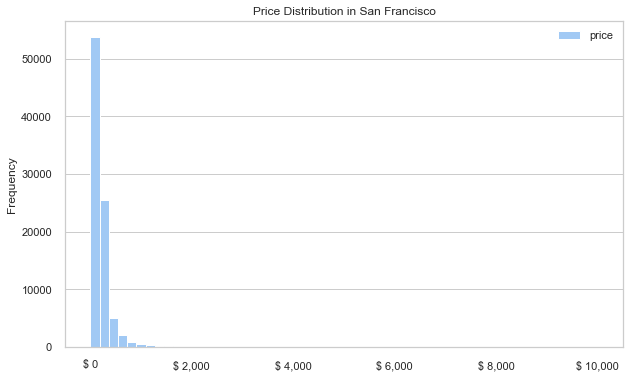

In [33]:
#Airbnb price distributions
listings.price.plot(kind = 'hist', bins=55,  title='Price Distribution in San Francisco',
          legend = True, figsize=(10,6));

#Get axis object
ax = plt.gca()

#Format X axis
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "$ {:,}".format(int(x))))

#Mute grid lines
ax.grid(b=False, which ='major', axis = 'x')

In [34]:
print(listings.shape)

(88937, 66)


In [35]:
#Calculate IQR of price
q25 = listings['price'].quantile(0.25)
q75= listings['price'].quantile(0.75)
iqr = q75 - q25

#Print percentiles
print('Percentiles: 25th={:.3f}, 75th={:.3f} \nIQR= {:.3f}'.format(q25, q75, iqr))

#Calculate outlier cutoffs
cut_off =1.5 * iqr
lower, upper = q25 - cut_off, q75 + iqr

#Identify outliers
outliers = [x for x in listings.price if x < lower or x > upper]
print("Number of outliers identified: {}".format(len(outliers)))

#Remove outliers
outliers_removed = [x for x in listings.price if x >= lower and x <= upper]
print('Non-outlier observations: {}'.format(len(outliers_removed)))

#Update df
listings = listings[listings.price.isin(outliers_removed)]
listings.shape

Percentiles: 25th=100.000, 75th=240.000 
IQR= 140.000
Number of outliers identified: 8989
Non-outlier observations: 79948


(79948, 66)

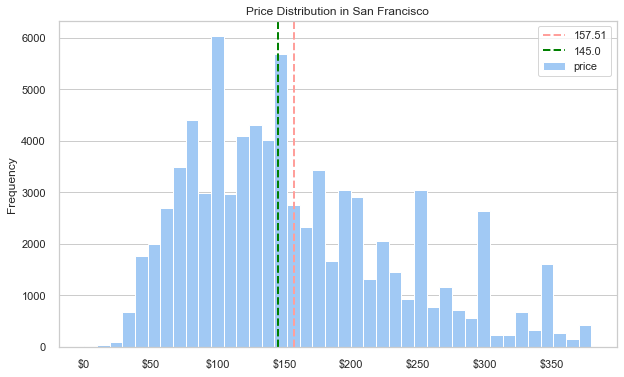

In [36]:
#Airbnb price distributions(outliers removed)
listings.price.plot(kind = 'hist', bins=40,  title='Price Distribution in San Francisco',
           figsize=(10,6));

#Capture mean and median of price
mean = listings.price.mean()
median = listings.price.median()

#Plot mean and median
plt.axvline(mean, color='r', linewidth=2, linestyle='--', label= str(round(mean,2)))
plt.axvline(median, color='green',linewidth=2, linestyle='--', label= str(median))

#Get axis object
ax = plt.gca()

#Format X axis
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))

#Mute grid lines
plt.grid(b=False, which ='major', axis = 'x')

plt.legend(loc='upper right',frameon=True, fancybox=True)


In [37]:
# #Set path to write listings
# path = r'Data\02_Intermediate\12_24_2019_listings_cleaned.csv'

# #Write listings to path
# listings.to_csv(path)